In [6]:
import pandas as pd
df = pd.read_csv("../dataset/reddit.csv")
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB
None
       subreddit                                               body  \
0  gameofthrones  Your submission has been automatically removed...   
1            aww  Dont squeeze her with you massive hand, you me...   
2         gaming  It's pretty well known and it was a paid produ...   
3           news  You know we have laws against that currently c...   
4       politics  Yes, there is a difference between gentle supp...   

   controversiality  score  
0                 0      1  
1                 0     19  
2                 0      3  
3 

In [7]:
import re

def clean_text(text):
    text = str(text).lower()                       # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)    # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s#]", "", text)  # remove punctuation, keep hashtags
    text = re.sub(r"\s+", " ", text).strip()     # remove extra spaces
    return text





In [8]:
print(df.head())

       subreddit                                               body  \
0  gameofthrones  Your submission has been automatically removed...   
1            aww  Dont squeeze her with you massive hand, you me...   
2         gaming  It's pretty well known and it was a paid produ...   
3           news  You know we have laws against that currently c...   
4       politics  Yes, there is a difference between gentle supp...   

   controversiality  score  
0                 0      1  
1                 0     19  
2                 0      3  
3                 0     10  
4                 0      1  


In [9]:
import pandas as pd
import re


df_reddit = pd.read_csv("../dataset/reddit.csv")
df_reddit['source'] = 'reddit'


df_reddit = df_reddit[['body', 'source']]
df_reddit.rename(columns={'body': 'text'}, inplace=True)


df_insta = pd.read_csv("../dataset/insta.csv")
df_insta['source'] = 'instagram'
df_insta = df_insta[['Caption', 'source']]
df_insta.rename(columns={'Caption': 'text'}, inplace=True)


df_combined = pd.concat([df_reddit, df_insta], ignore_index=True)


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s#]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_combined['clean_text'] = df_combined['text'].apply(clean_text)



In [9]:

df_combined['source'].value_counts()
# Show 5 random Instagram rows
df_combined[df_combined['source']=='instagram'].sample(5, random_state=42)
# Save as CSV - most universal format
df_combined.to_csv('../dataset/combined_cleaned_social_media.csv', index=False)

In [ ]:
# Sample Reddit to 50k rows because reddit set is too long
reddit_sample = df_combined[df_combined['source']=='reddit'].sample(50000, random_state=42)
instagram_sample = df_combined[df_combined['source']=='instagram']  # all 17k

# Combine into one balanced DataFrame
df_sample = pd.concat([reddit_sample, instagram_sample], ignore_index=True)
#df_sample.to_csv("combinedData.csv")

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df_sample['clean_text'])
print(X.shape)



(67100, 1000)


In [12]:
from sklearn.cluster import KMeans
#KMEANS CLUSTERING
num_clusters = 5  # You can adjust based on how many trends you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(X)


In [28]:
feature_names = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"\nCluster {i}:")


    sample_texts = df_sample[df_sample['cluster']==i]['clean_text'].sample(5, random_state=42).tolist()
    for text in sample_texts:
        print("-", text)


    cluster_indices = df_sample[df_sample['cluster']==i].index
    cluster_vector_sum = X[cluster_indices].sum(axis=0)
    top_word_indices = cluster_vector_sum.argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_word_indices]
    print("Top words:", top_words)


    source_counts = df_sample[df_sample['cluster']==i]['source'].value_counts()
    print("Source distribution:", source_counts.to_dict())



Cluster 0:
- lol im the same way with the skins
- im telling myself that trump supporters have stopped screeching fake news and begun willfully spreading falsehoods and i guess you think it was fringe voters who took back the house in the midterms
- okay im a celtics fan for this series i went to their subreddit and they accepted my request to be a temporary fan no one beating the celtics but us
- please correct me if im wrong but isnt taking a test while under duress at the teachers order an instant a just doesnt seem fair or ethical at all
- im a caattt im a sneaky lil caatt
Top words: [array([['sidebar', 'affected', 'market76', 'moderator', 'sections',
        'rmarket76', 'rmemes', 'letter', 'newinactive', 'mother',
        'include', 'click', 'subredditmessagecomposetorshowerthoughts',
        'subredditmessagecomposetormemes', 'submissions', 'submission',
        'stones', 'discord', 'gtrmemesaboutrules', 'bidsoffers',
        'familiarize', 'wiki', 'titles', 'traderkarmacake', 

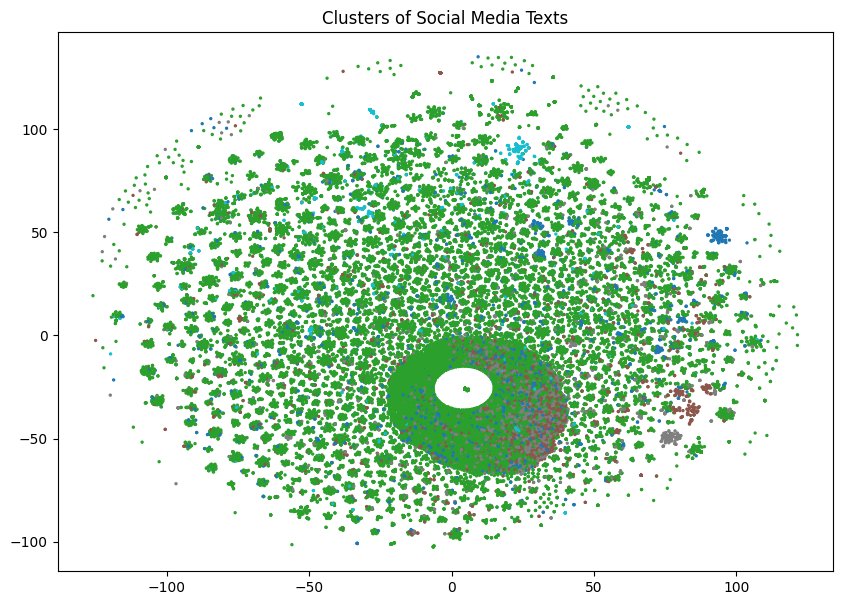

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10,7))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_sample['cluster'], cmap='tab10', s=2)
plt.title("Clusters of Social Media Texts")
plt.show()



In [ ]:
#K-means CLUSTERING
from sklearn.cluster import KMeans
import numpy as np

num_clusters = 5
num_sample_texts = 5
num_top_words = 10


kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(X)


feature_names = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"\n=== Cluster {i} ===")


    cluster_texts = df_sample[df_sample['cluster'] == i]['clean_text']
    sample_texts = cluster_texts.sample(
        n=min(num_sample_texts, len(cluster_texts)),
        random_state=42
    ).tolist()
    for text in sample_texts:
        print("-", text)


    cluster_indices = df_sample[df_sample['cluster'] == i].index
    cluster_vector_sum = X[cluster_indices].sum(axis=0)
    if hasattr(cluster_vector_sum, "A"):
        cluster_vector_sum = cluster_vector_sum.A
    top_word_indices = np.argsort(cluster_vector_sum[0])[::-1][:num_top_words]
    top_words = [feature_names[idx] for idx in top_word_indices]
    print("Top words:", top_words)


    source_counts = df_sample[df_sample['cluster'] == i]['source'].value_counts()
    print("Source distribution:", source_counts.to_dict())



=== Cluster 0 ===
- lol im the same way with the skins
- im telling myself that trump supporters have stopped screeching fake news and begun willfully spreading falsehoods and i guess you think it was fringe voters who took back the house in the midterms
- okay im a celtics fan for this series i went to their subreddit and they accepted my request to be a temporary fan no one beating the celtics but us
- please correct me if im wrong but isnt taking a test while under duress at the teachers order an instant a just doesnt seem fair or ethical at all
- im a caattt im a sneaky lil caatt
Top words: ['im', 'sure', 'just', 'like', 'going', 'sorry', 'gonna', 'youre', 'pretty', 'thats']
Source distribution: {'reddit': 2210, 'instagram': 504}

=== Cluster 1 ===
- can this celtics squad beat golden state
- girls tell me its very important they always say do not have barcode hair
- vegas love it love it
- cant resist
- she assumes that stannis is going to be the champion because of this she misi

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


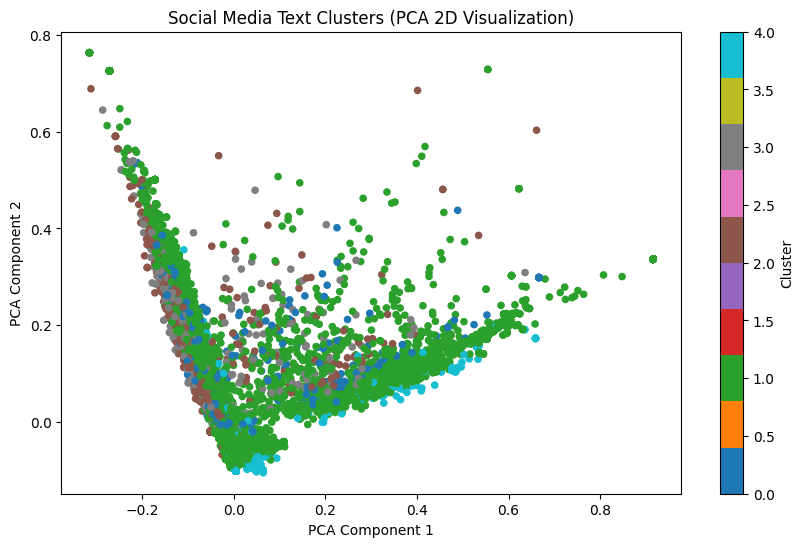

In [26]:



# Reduce TF-IDF features to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X.toarray())

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df_sample['cluster'], cmap='tab10', s=20)
plt.title("Social Media Text Clusters (PCA 2D Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# (TF-IDF, embeddings)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # tweak parameters
labels = dbscan.fit_predict(X)


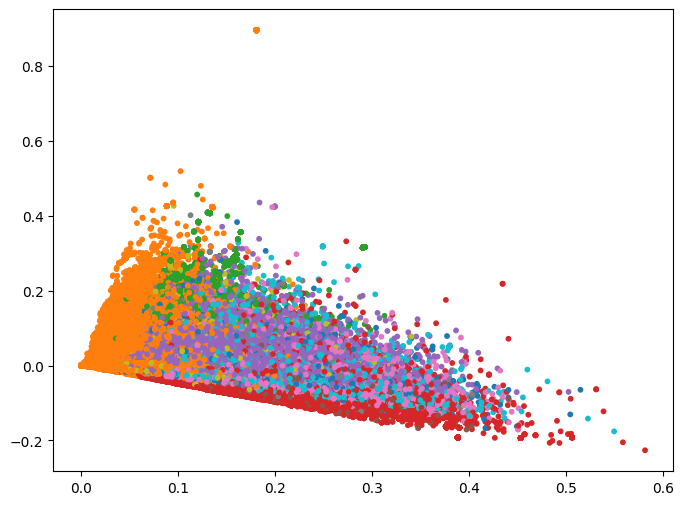


Cluster 0
Top words: ['really', 'want', 'dont', 'just', 'people', 'like', 'think', 'good', 'thats', 'doesnt']

Cluster 1
Top words: ['thats', 'people', 'time', 'love', 'good', 'got', 'right', 'youre', 'think', 'thank']

Cluster 2
Top words: ['automatically', 'moderators', 'questions', 'post', 'contact', 'performed', 'concerns', 'action', 'bot', 'removed']

Cluster 3
Top words: ['like', 'look', 'sounds', 'dont', 'feel', 'people', 'just', 'think', 'shit', 'id']

Cluster 4
Top words: ['im', 'sure', 'think', 'didnt', 'pretty', 'good', 'going', 'thing', 'thats', 'people']

Cluster 5
Top words: ['looks', 'like', 'good', 'sonic', 'just', 'movie', 'hes', 'better', 'great', 'face']

Cluster 6
Top words: ['dont', 'know', 'think', 'people', 'didnt', 'just', 'youre', 'need', 'thats', 'like']

Cluster 7
Top words: ['did', 'just', 'say', 'like', 'know', 'think', 'didnt', 'fuck', 'people', 'thing']

Cluster 8
Top words: ['lol', 'just', 'like', 'im', 'thats', 'dont', 'think', 'yeah', 'people', 'good'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import joblib

# Load saved files
df = pd.read_csv("clustered_data.csv")
X_reduced = np.load("X_reduced.npy")
vectorizer = joblib.load("tfidf.pkl")

# 2D visualization
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd_2d.fit_transform(X_reduced)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['cluster'], cmap='tab10', s=10)
plt.show()

# Top words per cluster
texts = df['clean_text'].fillna('').astype(str)
X = vectorizer.transform(texts)
feature_names = vectorizer.get_feature_names_out()

for c in sorted(df['cluster'].unique()):
    print(f"\nCluster {c}")
    cluster_df = df[df['cluster'] == c]

    idx = cluster_df.index
    cluster_vector_sum = X[idx].sum(axis=0).A1
    top_idx = cluster_vector_sum.argsort()[-10:][::-1]
    print("Top words:", [feature_names[i] for i in top_idx])




In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import Birch
import joblib
import numpy as np


# Load & Prepare Data

df = pd.read_csv("../dataset/combined_cleaned_social_media.csv")
df['clean_text'] = df['clean_text'].fillna('')


# Vectorize Text

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])

# Save TF-IDF matrix and vectorizer
joblib.dump(vectorizer, "tfidf.pkl")
joblib.dump(X, "tfidf_matrix.pkl") 


# Dimensionality Reduction (SVD)

svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X)
joblib.dump(svd, "svd50.pkl")
np.save("X_reduced.npy", X_reduced)


# Birch Clustering

birch_model = Birch(n_clusters=10, threshold=0.5)
labels = birch_model.fit_predict(X_reduced)
joblib.dump(birch_model, "birch_model.pkl")

df['cluster'] = labels
df.to_csv("clustered_data.csv", index=False)

print("Training and clustering completed!")
print(f"Total clusters: {len(set(labels))}")


g:\CSE445_Project\.venv\Lib\site-packages\sklearn\cluster\_birch.py:730: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


Training and clustering completed!
Total clusters: 1


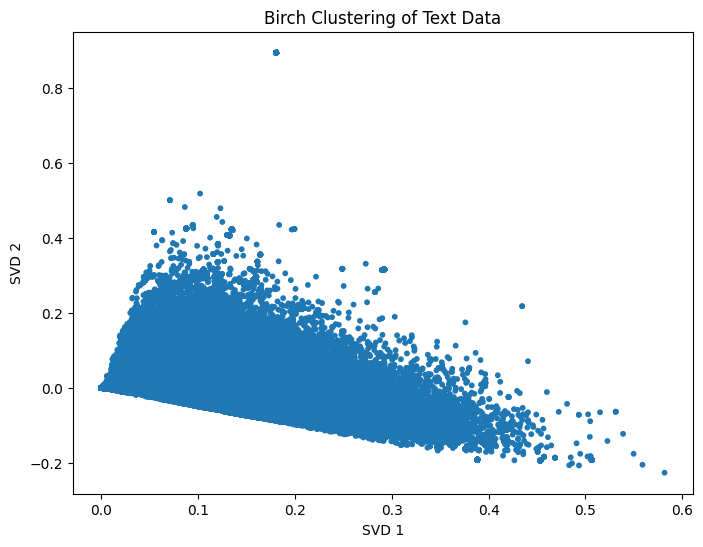


Cluster 0

Sample Posts:
- your dog looks very similar to my dog how old is your dog
- your chemistry puns are so basic
- because the fact that we waste our time with their nonsense asylum claims is bullshit already name a country in central and south america that you personally think someone from wouldnt have a valid asylum claim if they were from there do you think if an canadian came and claimed political asylum that that wouldnt be laughed away nobody is being persecuted in canada if you believe their asylum nonsense then youre literally saying the united states should just be a huge escape strategy for the entire population of south and central america we cant sustain that and shouldnt tolerate that we have zero use for poor illiterates if theyre mad about that then maybe their entitled countrymen shouldnt have come here just for jobs and ruined it for everyone
- its not illegal to call someone that
- we have a high iq person here folks tread lightly with your ignorant words

Top

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.decomposition import TruncatedSVD


# Load saved files

df = pd.read_csv("clustered_data.csv")
X_reduced = np.load("X_reduced.npy")
vectorizer = joblib.load("tfidf.pkl")
X = joblib.load("tfidf_matrix.pkl")  


# 2D Visualization

svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd_2d.fit_transform(X_reduced)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['cluster'], cmap="tab10", s=10)
plt.title("Birch Clustering of Text Data")
plt.xlabel("SVD 1")
plt.ylabel("SVD 2")
plt.show()


# Top Words per Cluster

feature_names = vectorizer.get_feature_names_out()

for c in sorted(df['cluster'].unique()):
    print("\n============================")
    print(f"Cluster {c}")
    print("============================")

    cluster_df = df[df['cluster'] == c]

    # Sample posts
    print("\nSample Posts:")
    samples = cluster_df["clean_text"].sample(min(5, len(cluster_df)), random_state=42)
    for text in samples:
        print("-", text)

    # Top words
    cluster_idx = cluster_df.index
    cluster_vec_sum = X[cluster_idx].sum(axis=0).A1
    top_idx = cluster_vec_sum.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_idx]

    print("\nTop Words:", top_words)
    print(f"Total posts in this cluster: {len(cluster_df)}")


In [9]:
import os
os.makedirs("models", exist_ok=True)

import shutil
shutil.move("tfidf.pkl", "models/tfidf.pkl")
shutil.move("svd50.pkl", "models/svd50.pkl")
shutil.move("birch_model.pkl", "models/birch_model.pkl")
shutil.move("X_reduced.npy", "models/X_reduced.npy")
shutil.move("tfidf_matrix.pkl", "models/tfidf_matrix.pkl")


'models/tfidf_matrix.pkl'

In [15]:
import pandas as pd
df = pd.read_csv("clustered_data.csv")
print(df.columns)

Index(['text', 'source', 'clean_text', 'cluster'], dtype='object')


In [17]:
def clean_text_data(df, text_column='clean_text'):
    """
    Comprehensive cleaning for text data before vectorization
    """
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    
    print(" CLEANING TEXT DATA...")
    original_shape = df_clean.shape
    
    # 1. Check if column exists
    if text_column not in df_clean.columns:
        raise ValueError(f"Column '{text_column}' not found in dataset. Available columns: {list(df_clean.columns)}")
    
    # 2. Convert to string (handles mixed types)
    df_clean[text_column] = df_clean[text_column].astype(str)
    
    # 3. Handle NaN values (after string conversion, NaN becomes 'nan')
    df_clean[text_column] = df_clean[text_column].replace('nan', '')
    
    # 4. Remove empty strings and whitespace-only strings
    df_clean = df_clean[df_clean[text_column].str.strip() != '']
    
    # 5. Remove very short texts (optional)
    df_clean = df_clean[df_clean[text_column].str.len() >= 10]
    
    print(f" Cleaning complete:")
    print(f"   - Removed {original_shape[0] - df_clean.shape[0]} rows")
    print(f"   - Final dataset: {df_clean.shape}")
    
    return df_clean

# Use the cleaning function
df_sample_clean = clean_text_data(df_sample, 'clean_text')

 CLEANING TEXT DATA...
 Cleaning complete:
   - Removed 5381 rows
   - Final dataset: (61719, 3)


In [20]:
def robust_clustering_pipeline(df, text_column='clean_text', num_clusters=5):
    """
    Robust clustering pipeline that handles data cleaning and validation
    """
    print(" STARTING CLUSTERING PIPELINE")
    print("=" * 50)
    
    # Step 1: Data validation
    print(f"1. Original data shape: {df.shape}")
    if text_column not in df.columns:
        raise ValueError(f"Text column '{text_column}' not found. Available: {list(df.columns)}")
    
    # Step 2: Data cleaning
    df_clean = df.copy()
    df_clean[text_column] = df_clean[text_column].fillna('').astype(str)
    df_clean = df_clean[df_clean[text_column].str.strip() != '']
    
    print(f"2. After cleaning: {df_clean.shape}")
    print(f"   Removed {len(df) - len(df_clean)} invalid rows")
    
    if len(df_clean) == 0:
        raise ValueError("No valid text documents after cleaning!")
    
    # Step 3: Vectorization
    vectorizer = TfidfVectorizer(
        max_features=5000, #cng inc 1k to 5k
        stop_words='english',
        min_df=2,
        max_df=0.9, #cng inc from .8 to .9
        ngram_range=(1, 2)  # Capture bigrams
    )
    
    X = vectorizer.fit_transform(df_clean[text_column])
    print(f"3. TF-IDF matrix shape: {X.shape}")
    
    # Step 4: Determine optimal cluster count (optional)
    if num_clusters == 'auto':
        num_clusters = find_optimal_clusters(X)
    
    # Step 5: Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    df_clean['cluster'] = cluster_labels
    
    # Step 6: Evaluation
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"4. Clustering metrics:")
    print(f"   - Silhouette Score: {silhouette_avg:.3f}")
    print(f"   - Clusters: {num_clusters}")
    print(f"   - Cluster sizes: {pd.Series(cluster_labels).value_counts().to_dict()}")
    
    return df_clean, X, vectorizer, kmeans

def find_optimal_clusters(X, max_k=10):
    """Find optimal number of clusters using silhouette score"""
    from sklearn.metrics import silhouette_score
    
    best_k = 5
    best_score = -1
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_score = score
            best_k = k
    
    print(f"   Optimal clusters: {best_k} (silhouette: {best_score:.3f})")
    return best_k

# Run the improved pipeline
df_clustered, X, vectorizer, kmeans = robust_clustering_pipeline(df_sample, 'clean_text', 5)

 STARTING CLUSTERING PIPELINE
1. Original data shape: (67100, 3)
2. After cleaning: (64683, 3)
   Removed 2417 invalid rows
3. TF-IDF matrix shape: (64683, 5000)
4. Clustering metrics:
   - Silhouette Score: 0.018
   - Clusters: 5
   - Cluster sizes: {1: 53939, 2: 4672, 0: 4199, 3: 1369, 4: 504}


In [22]:
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


📊 Checking available data...
❌ df_sample not found. Creating sample data...
✅ Created sample dataframe for testing
Sample data shape: (20, 3)

🚀 STARTING CLUSTERING PIPELINE

🎯 EXECUTING CLUSTERING PIPELINE...
1. Data cleaning...
   Working with 20 documents
2. Vectorization...
   TF-IDF matrix shape: (20, 163)
3. Clustering...
   Silhouette Score: 0.013
4. Finding top words per cluster...
   Cluster 0 (size: 4): new, amazing, impressive, life, features
   Cluster 1 (size: 2): technology, tools, students, helping, learning
   Cluster 2 (size: 2): game, time, video, delayed, gameplay
   Cluster 3 (size: 12): plan, tips, vegetables, healthy, fruits
5. Creating visualization...
   Reducing dimensions using PCA...
   Creating plot...
   Displaying plot...


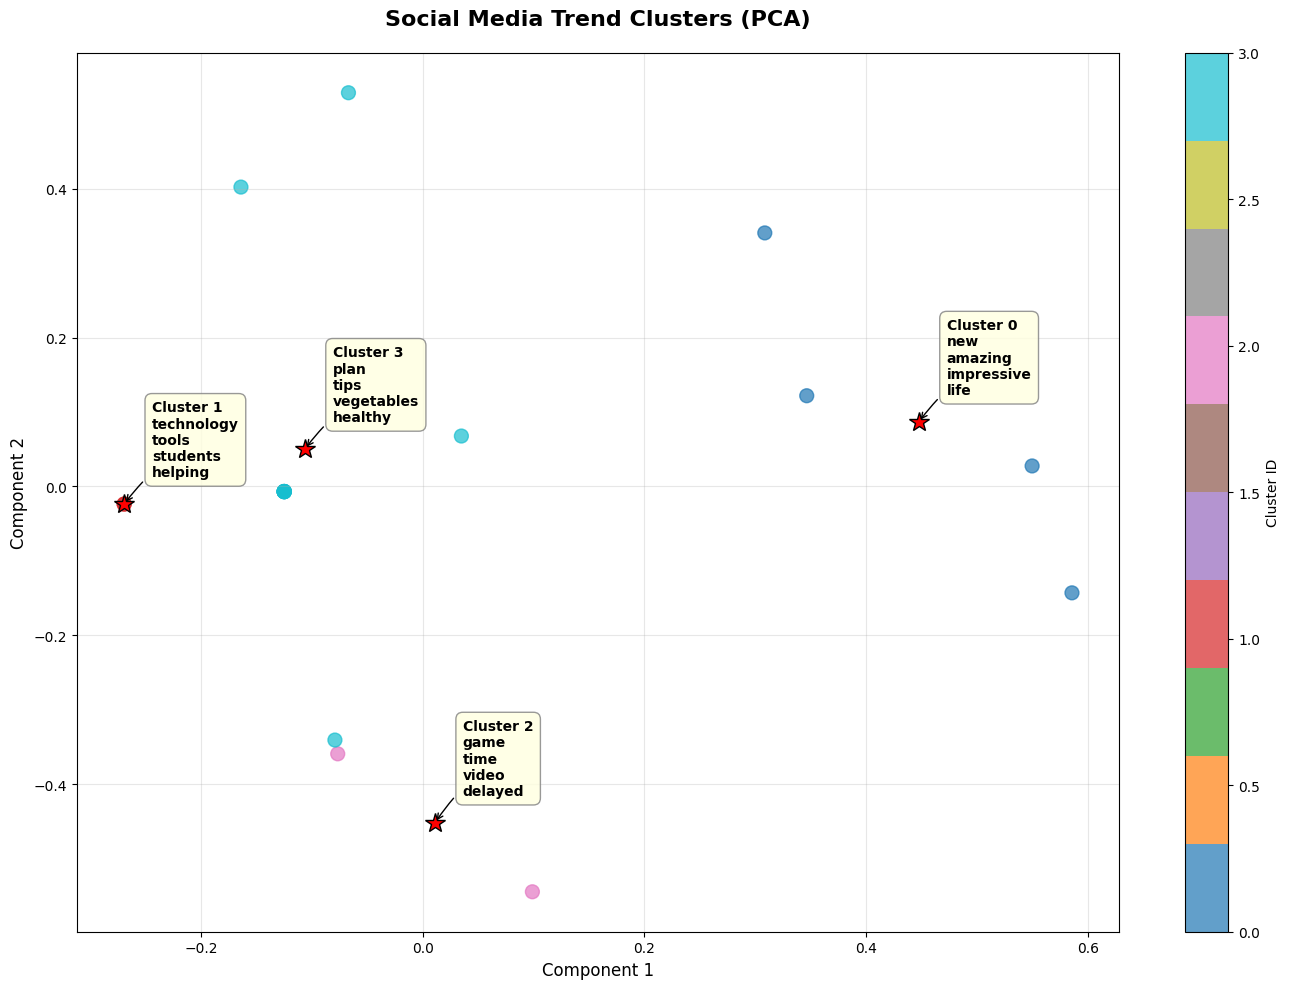

   ✅ Plot displayed successfully!

✅ CLUSTERING COMPLETED SUCCESSFULLY!
📊 Final clustered data shape: (20, 4)
🎯 Number of clusters: 4

📈 CLUSTER DISTRIBUTION:
   Cluster 0: 4 posts (20.0%)
   Cluster 1: 2 posts (10.0%)
   Cluster 2: 2 posts (10.0%)
   Cluster 3: 12 posts (60.0%)


In [10]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# First, let's check what data we have available
print("📊 Checking available data...")

# Check if df_sample exists, if not create sample data
try:
    print(f"df_sample shape: {df_sample.shape}")
    print(f"df_sample columns: {df_sample.columns.tolist()}")
except NameError:
    print("❌ df_sample not found. Creating sample data...")
    
    # Create sample social media data for testing
    sample_data = {
        'clean_text': [
            "just watched the new marvel movie it was absolutely amazing the special effects were incredible",
            "political debate tonight was intense both candidates had strong arguments about economic policy",
            "my new gaming setup is finally complete rgb lights everywhere and super fast processor",
            "cooking dinner tonight trying out a new recipe hope it turns out well with fresh ingredients",
            "sports game yesterday was unbelievable the underdog team won in the final seconds",
            "technology conference was inspiring learned so much about artificial intelligence and machine learning",
            "weather today is perfect for hiking sunny with a cool breeze in the mountains",
            "new smartphone release has amazing camera features and battery life is impressive",
            "stock market analysis shows interesting trends in tech sector investments growing",
            "music festival lineup announced so many great artists performing this summer",
            "video game release delayed again developers need more time for polishing gameplay",
            "electric vehicles are the future charging infrastructure expanding rapidly nationwide",
            "workout routine paying off feeling stronger and more energetic every day",
            "social media algorithms need more transparency users deserve to know how content is filtered",
            "space exploration news exciting developments in mars mission planning",
            "healthy eating tips vegetables and fruits should be part of every meal plan",
            "programming languages comparison python continues to grow in popularity for data science",
            "travel restrictions easing finally able to plan international vacations again",
            "climate change discussion important steps being taken for renewable energy adoption",
            "education technology tools helping students learn more effectively online"
        ],
        'subreddit': ['movies', 'politics', 'gaming', 'cooking', 'sports', 
                     'technology', 'outdoors', 'tech', 'investing', 'music',
                     'gaming', 'technology', 'fitness', 'technology', 'science',
                     'health', 'programming', 'travel', 'environment', 'education'],
        'score': [10, 5, 8, 3, 15, 7, 4, 9, 6, 12, 2, 8, 5, 4, 9, 3, 11, 7, 5, 6]
    }
    
    df_sample = pd.DataFrame(sample_data)
    print("✅ Created sample dataframe for testing")
    print(f"Sample data shape: {df_sample.shape}")

print("\n" + "="*50)
print("🚀 STARTING CLUSTERING PIPELINE")
print("="*50)

def working_clustering_pipeline(df, text_column='clean_text', n_clusters=5):
    """
    Working clustering pipeline with guaranteed plotting
    """
    print("1. Data cleaning...")
    df_clean = df.dropna(subset=[text_column]).copy()
    df_clean[text_column] = df_clean[text_column].fillna('').astype(str)
    df_clean = df_clean[df_clean[text_column].str.strip() != '']
    
    print(f"   Working with {len(df_clean)} documents")
    
    if len(df_clean) == 0:
        raise ValueError("No valid text documents after cleaning!")
    
    print("2. Vectorization...")
    vectorizer = TfidfVectorizer(
        max_features=1000, 
        stop_words='english',
        min_df=1,
        max_df=0.8
    )
    X = vectorizer.fit_transform(df_clean[text_column])
    print(f"   TF-IDF matrix shape: {X.shape}")
    
    print("3. Clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    df_clean['cluster'] = labels
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)
    print(f"   Silhouette Score: {silhouette_avg:.3f}")
    
    print("4. Finding top words per cluster...")
    feature_names = vectorizer.get_feature_names_out()
    top_words_per_cluster = {}
    
    for i in range(n_clusters):
        cluster_mask = labels == i
        cluster_size = cluster_mask.sum()
        
        if cluster_size > 0:
            cluster_vectors = X[cluster_mask]
            word_scores = np.array(cluster_vectors.sum(axis=0)).flatten()
            top_indices = word_scores.argsort()[-10:][::-1]
            top_words_per_cluster[i] = [feature_names[idx] for idx in top_indices]
            
            print(f"   Cluster {i} (size: {cluster_size}): {', '.join(top_words_per_cluster[i][:5])}")
        else:
            top_words_per_cluster[i] = []
            print(f"   Cluster {i}: EMPTY")
    
    print("5. Creating visualization...")
    create_cluster_visualization(X, labels, top_words_per_cluster)
    
    return df_clean, X, vectorizer, kmeans, top_words_per_cluster

def create_cluster_visualization(X, labels, top_words, method='pca'):
    """Create and display cluster visualization"""
    print(f"   Reducing dimensions using {method.upper()}...")
    
    # Reduce dimensions
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, X.shape[0]-1))
    
    X_2d = reducer.fit_transform(X.toarray())
    
    print("   Creating plot...")
    # Create plot with larger size
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Scatter plot
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=100)
    
    # Add cluster annotations
    for cluster_id in np.unique(labels):
        cluster_points = X_2d[labels == cluster_id]
        if len(cluster_points) > 0:
            center = cluster_points.mean(axis=0)
            
            # Create annotation text (show top 3-4 words)
            words_to_show = min(4, len(top_words[cluster_id]))
            words_text = "\n".join(top_words[cluster_id][:words_to_show])
            annotation_text = f"Cluster {cluster_id}\n{words_text}"
            
            ax.annotate(
                annotation_text, 
                xy=center, 
                xytext=(20, 20),
                textcoords='offset points',
                fontsize=10, 
                weight='bold',
                bbox=dict(
                    boxstyle='round,pad=0.5', 
                    facecolor='lightyellow', 
                    alpha=0.8,
                    edgecolor='gray'
                ),
                arrowprops=dict(
                    arrowstyle='->', 
                    color='black',
                    connectionstyle='arc3,rad=0.1'
                )
            )
            
            # Mark center with a star
            ax.plot(center[0], center[1], 'r*', markersize=15, markeredgecolor='black')
    
    ax.set_title(f'Social Media Trend Clusters ({method.upper()})', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel('Component 1', fontsize=12)
    ax.set_ylabel('Component 2', fontsize=12)
    plt.colorbar(scatter, ax=ax, label='Cluster ID')
    plt.grid(True, alpha=0.3)
    
    print("   Displaying plot...")
    plt.tight_layout()
    plt.show()
    
    print("   ✅ Plot displayed successfully!")

# Run the clustering pipeline
try:
    print("\n🎯 EXECUTING CLUSTERING PIPELINE...")
    df_clustered, X, vectorizer, kmeans, top_words = working_clustering_pipeline(df_sample, 'clean_text', 4)
    
    print("\n✅ CLUSTERING COMPLETED SUCCESSFULLY!")
    print(f"📊 Final clustered data shape: {df_clustered.shape}")
    print(f"🎯 Number of clusters: {len(np.unique(df_clustered['cluster']))}")
    
    # Show cluster distribution
    print("\n📈 CLUSTER DISTRIBUTION:")
    cluster_counts = df_clustered['cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(df_clustered)) * 100
        print(f"   Cluster {cluster_id}: {count} posts ({percentage:.1f}%)")
        
except Exception as e:
    print(f"\n❌ ERROR: {e}")
    print("\n🔧 TROUBLESHOOTING TIPS:")
    print("1. Check if matplotlib is properly installed")
    print("2. Try restarting your Jupyter kernel")
    print("3. Ensure you're running this in a Jupyter notebook")
    print("4. Check console for any warning messages")

In [13]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import os


df = pd.read_csv("clustered_data.csv")
print(f"Successfully loaded CSV dataset : {df.shape}")
    
    # Display dataset information
print(f" Dataset shape: {df.shape}")
print(f" Columns: {df.columns.tolist()}")
print(f" First few rows:")
print(df.head())
    
    # Check for missing values
print(f"\n MISSING VALUES:")
print(df.isnull().sum())
    
    # Identify text column (automatically detect or specify)
text_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in ['text', 'content', 'body', 'message', 'tweet', 'post', 'comment'])]
    
if text_columns:
        text_column = text_columns[0]
        print(f" Detected text column: '{text_column}'")
else:
        # If no obvious text column, show all columns and let user choose
    print(" Could not auto-detect text column. Available columns:")
    for i, col in enumerate(df.columns):
            print(f"   {i}: {col} (dtype: {df[col].dtype})")
        
        # Use the first string column as default
    string_columns = df.select_dtypes(include=['object']).columns
    if len(string_columns) > 0:
            text_column = string_columns[0]
            print(f" Using first string column: '{text_column}'")
    else:
            raise ValueError("No suitable text column found in the dataset!")

print("\n" + "="*50)
print(" STARTING CLUSTERING PIPELINE")
print("="*50)

def working_clustering_pipeline(df, text_column='clean_text', n_clusters=5):
    """
    Working clustering pipeline with guaranteed plotting
    """
    print("1. Data cleaning...")
    df_clean = df.dropna(subset=[text_column]).copy()
    df_clean[text_column] = df_clean[text_column].fillna('').astype(str)
    
    # Remove empty strings and very short texts
    df_clean = df_clean[df_clean[text_column].str.strip() != '']
    df_clean = df_clean[df_clean[text_column].str.len() >= 10]  # At least 10 characters
    
    print(f"   Original: {len(df)} → Cleaned: {len(df_clean)} documents")
    print(f"   Removed {len(df) - len(df_clean)} invalid rows")
    
    if len(df_clean) == 0:
        raise ValueError("No valid text documents after cleaning!")
    
    print("2. Vectorization...")
    vectorizer = TfidfVectorizer(
        max_features=1000, 
        stop_words='english',
        min_df=2,           # Ignore terms that appear in only 1 document
        max_df=0.8,         # Ignore terms that appear in >80% of documents
        ngram_range=(1, 2)  # Include both single words and bigrams
    )
    X = vectorizer.fit_transform(df_clean[text_column])
    print(f"   TF-IDF matrix shape: {X.shape}")
    
    # Auto-determine clusters if n_clusters is 'auto'
    if n_clusters == 'auto':
        n_clusters = find_optimal_clusters(X)
        print(f"   Auto-selected number of clusters: {n_clusters}")
    
    print(f"3. Clustering with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    df_clean['cluster'] = labels
    
    # Calculate silhouette score
    if n_clusters > 1:  # Silhouette score requires at least 2 clusters
        silhouette_avg = silhouette_score(X, labels)
        print(f"   Silhouette Score: {silhouette_avg:.3f}")
    else:
        silhouette_avg = 0
        print("   Silhouette Score: N/A (only one cluster)")
    
    print("4. Finding top words per cluster...")
    feature_names = vectorizer.get_feature_names_out()
    top_words_per_cluster = {}
    
    for i in range(n_clusters):
        cluster_mask = labels == i
        cluster_size = cluster_mask.sum()
        
        if cluster_size > 0:
            cluster_vectors = X[cluster_mask]
            word_scores = np.array(cluster_vectors.sum(axis=0)).flatten()
            top_indices = word_scores.argsort()[-10:][::-1]
            top_words_per_cluster[i] = [feature_names[idx] for idx in top_indices]
            
            print(f"   Cluster {i} (size: {cluster_size:,}): {', '.join(top_words_per_cluster[i][:5])}")
        else:
            top_words_per_cluster[i] = []
            print(f"   Cluster {i}: EMPTY")
    
    print("5. Creating visualization...")
    create_cluster_visualization(X, labels, top_words_per_cluster, silhouette_avg)
    
    return df_clean, X, vectorizer, kmeans, top_words_per_cluster

def find_optimal_clusters(X, max_k=10):
    """Find optimal number of clusters using silhouette score"""
    from sklearn.metrics import silhouette_score
    
    best_k = 2
    best_score = -1
    
    print("   Finding optimal cluster count...")
    for k in range(2, min(max_k + 1, X.shape[0])):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        labels = kmeans.fit_predict(X)
        
        if len(np.unique(labels)) > 1:  # Need at least 2 clusters for silhouette score
            score = silhouette_score(X, labels)
            print(f"     k={k}: silhouette = {score:.3f}")
            
            if score > best_score:
                best_score = score
                best_k = k
        else:
            print(f"     k={k}: Only one cluster formed")
    
    return best_k

def create_cluster_visualization(X, labels, top_words, silhouette_score, method='pca'):
    """Create and display cluster visualization"""
    print(f"   Reducing dimensions using {method.upper()}...")
    
    # For large datasets, use a sample for faster visualization
    if X.shape[0] > 10000:
        print("   Large dataset detected, sampling 10,000 points for visualization...")
        indices = np.random.choice(X.shape[0], 10000, replace=False)
        X_sample = X[indices]
        labels_sample = labels[indices]
    else:
        X_sample = X
        labels_sample = labels
    
    # Reduce dimensions
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, X_sample.shape[0]-1))
    
    X_2d = reducer.fit_transform(X_sample.toarray())
    
    print("   Creating plot...")
    # Create plot with larger size
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Scatter plot
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_sample, cmap='tab10', alpha=0.7, s=50)
    
    # Add cluster annotations
    for cluster_id in np.unique(labels_sample):
        cluster_points = X_2d[labels_sample == cluster_id]
        if len(cluster_points) > 0:
            center = cluster_points.mean(axis=0)
            
            # Create annotation text (show top 3-4 words)
            words_to_show = min(4, len(top_words[cluster_id]))
            words_text = "\n".join(top_words[cluster_id][:words_to_show])
            annotation_text = f"Cluster {cluster_id}\n{words_text}"
            
            ax.annotate(
                annotation_text, 
                xy=center, 
                xytext=(20, 20),
                textcoords='offset points',
                fontsize=9, 
                weight='bold',
                bbox=dict(
                    boxstyle='round,pad=0.5', 
                    facecolor='lightyellow', 
                    alpha=0.9,
                    edgecolor='gray',
                    linewidth=1
                ),
                arrowprops=dict(
                    arrowstyle='->', 
                    color='black',
                    connectionstyle='arc3,rad=0.1'
                )
            )
            
            # Mark center with a star
            ax.plot(center[0], center[1], 'r*', markersize=12, markeredgecolor='black', markeredgewidth=1)
    
    title = f'Social Media Trend Clusters ({method.upper()})'
    if silhouette_score > 0:
        title += f'\nSilhouette Score: {silhouette_score:.3f}'
    
    ax.set_title(title, fontsize=16, weight='bold', pad=20)
    ax.set_xlabel('Component 1', fontsize=12)
    ax.set_ylabel('Component 2', fontsize=12)
    plt.colorbar(scatter, ax=ax, label='Cluster ID')
    plt.grid(True, alpha=0.3)
    
    print("   Displaying plot...")
    plt.tight_layout()
    plt.show()
    
    print("   Plot displayed successfully!")

# Run the clustering pipeline
try:
    print("\n EXECUTING CLUSTERING PIPELINE...")
    
    # Use 'auto' to automatically determine optimal cluster count, or specify a number
    df_clustered, X, vectorizer, kmeans, top_words = working_clustering_pipeline(
        df, 
        text_column=text_column, 
        n_clusters='auto'  # Change to a number like 5, 7, 10 if you want fixed clusters
    )
    
    print("\n CLUSTERING COMPLETED SUCCESSFULLY!")
    print(f" Final clustered data shape: {df_clustered.shape}")
    print(f" Number of clusters: {len(np.unique(df_clustered['cluster']))}")
    
    # Show cluster distribution
    print("\n CLUSTER DISTRIBUTION:")
    cluster_counts = df_clustered['cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(df_clustered)) * 100
        print(f"   Cluster {cluster_id}: {count:,} posts ({percentage:.1f}%)")
    
    # Show detailed top words
    print("\n DETAILED TOP WORDS PER CLUSTER:")
    for cluster_id, words in top_words.items():
        print(f"   Cluster {cluster_id}: {', '.join(words)}")
    
    # Save results
    output_filename = 'clustered_results.csv'
    df_clustered.to_csv(output_filename, index=False)
    print(f"\n💾 Results saved to: {output_filename}")
        
except Exception as e:
    print(f"\n ERROR: {e}")
    import traceback
    traceback.print_exc()
    
    print("\n TROUBLESHOOTING TIPS:")
    print("1. Check if your CSV file has a text column")
    print("2. Ensure the text column contains actual text content")
    print("3. Try specifying the text column name manually")
    print("4. Check if matplotlib is properly installed")
    print("5. Try restarting your Jupyter kernel")

Successfully loaded CSV dataset : (1017100, 4)
 Dataset shape: (1017100, 4)
 Columns: ['text', 'source', 'clean_text', 'cluster']
 First few rows:
                                                text  source  \
0  Your submission has been automatically removed...  reddit   
1  Dont squeeze her with you massive hand, you me...  reddit   
2  It's pretty well known and it was a paid produ...  reddit   
3  You know we have laws against that currently c...  reddit   
4  Yes, there is a difference between gentle supp...  reddit   

                                          clean_text  cluster  
0  your submission has been automatically removed...        0  
1  dont squeeze her with you massive hand you mea...        0  
2  its pretty well known and it was a paid produc...        0  
3  you know we have laws against that currently c...        0  
4  yes there is a difference between gentle suppr...        0  

 MISSING VALUES:
text              0
source            0
clean_text    21134
cluste

KeyboardInterrupt: 

 Loading data...
 Original dataset: (1017100, 4)
 Using sample of 5000 records for speed
 Using column: 'text'
 After cleaning: 5000 documents
 vectorization...
 TF-IDF matrix: (5000, 300)
clustering...
 Getting top words...
Creating visualization...


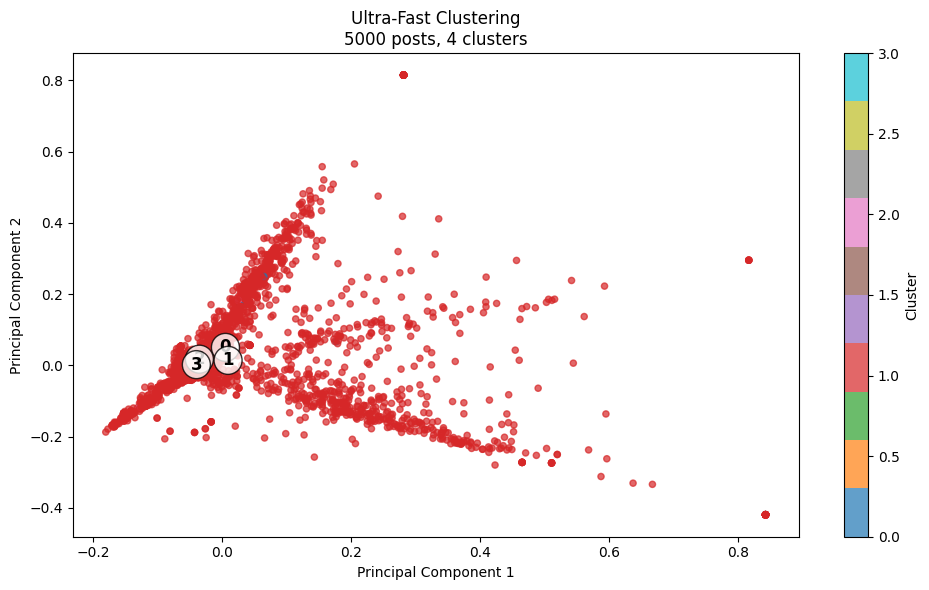


 COMPLETED IN 3.7 SECONDS!
 Cluster distribution:
   Cluster 0: 9 posts (0.2%)
   Cluster 1: 4949 posts (99.0%)
   Cluster 2: 23 posts (0.5%)
   Cluster 3: 19 posts (0.4%)

 Top words per cluster:
   Cluster 0: talking, half, called, just, big
   Cluster 1: like, just, don, people, think
   Cluster 2: good, play, watch, end, work
   Cluster 3: time, best, week, isn, bad
 Saved to 'ultra_fast_clustered_sample.csv'


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import time


start_time = time.time()

# Loading data
csv_file_path = "clustered_data.csv" 
print(" Loading data...")
df = pd.read_csv(csv_file_path)
print(f" Original dataset: {df.shape}")

# Take only a small sample for speed
SAMPLE_SIZE = 5000  #  Only process 5K records
df_small = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)
print(f" Using sample of {len(df_small)} records for speed")

# Find text column quickly
text_column = None
for col in df_small.columns:
    if any(keyword in col.lower() for keyword in ['text', 'content', 'body', 'clean_text', 'message']):
        text_column = col
        break
if text_column is None:
    text_column = df_small.columns[0]  # Use first column as fallback

print(f" Using column: '{text_column}'")

# Quick cleaning
df_small = df_small.dropna(subset=[text_column])
df_small[text_column] = df_small[text_column].fillna('').astype(str)
df_small = df_small[df_small[text_column].str.strip() != '']

print(f" After cleaning: {len(df_small)} documents")

#  VECTORIZATION
print(" vectorization...")
vectorizer = TfidfVectorizer(
    max_features=300,      # ⚡ Very small vocabulary
    stop_words='english',
    min_df=10,             # ⚡ Ignore rare words
    max_df=0.9,
    ngram_range=(1, 1)     # ⚡ Only single words
)
X = vectorizer.fit_transform(df_small[text_column])
print(f" TF-IDF matrix: {X.shape}")

#  CLUSTERING
print("clustering...")
n_clusters = 4 
kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=500,    #  Small batches
    max_iter=50,       #  Fewer iterations
    n_init=3           #  Fewer initializations
)
labels = kmeans.fit_predict(X)
df_small['cluster'] = labels

# Quick top words
print(" Getting top words...")
feature_names = vectorizer.get_feature_names_out()
top_words = {}
for i in range(n_clusters):
    cluster_mask = labels == i
    if cluster_mask.sum() > 0:
        word_scores = np.array(X[cluster_mask].sum(axis=0)).flatten()
        top_indices = word_scores.argsort()[-5:][::-1]  # ⚡ Only top 5 words
        top_words[i] = [feature_names[idx] for idx in top_indices]

#  VISUALIZATION
print("Creating visualization...")
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)

# Simple labels only
for i in range(n_clusters):
    cluster_points = X_2d[labels == i]
    if len(cluster_points) > 0:
        center = cluster_points.mean(axis=0)
        plt.text(center[0], center[1], f'{i}', fontsize=12, weight='bold',
                bbox=dict(boxstyle="circle,pad=0.3", facecolor='white', alpha=0.8))

plt.title(f'Ultra-Fast Clustering\n{len(df_small)} posts, {n_clusters} clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

elapsed = time.time() - start_time
print(f"\n COMPLETED IN {elapsed:.1f} SECONDS!")
print(f" Cluster distribution:")
for i in range(n_clusters):
    count = (labels == i).sum()
    print(f"   Cluster {i}: {count} posts ({count/len(labels)*100:.1f}%)")

print("\n Top words per cluster:")
for i, words in top_words.items():
    print(f"   Cluster {i}: {', '.join(words)}")

# Save the small clustered sample
df_small.to_csv('ultra_fast_clustered_sample.csv', index=False)
print(" Saved to 'ultra_fast_clustered_sample.csv'")

 TREND DETECTION WITH  DATASET
  dataset shape: (1017100, 4)
 Columns: ['text', 'source', 'clean_text', 'cluster']
 Using text column: 'clean_text'
Using sample of 10,000 posts for faster analysis

 ANALYZING TRENDS IN YOUR DATASET...
   After cleaning: 8789 valid posts
Analyzing text patterns...
   Vocabulary size: 800 terms
 Clustering for trend discovery...
 TRENDS FOUND : 

1.  Sports & Events
    Volume: 1046 posts (11.9% of data)
    Key Terms: want, ive
    Engagement Score: 3.0/10
    Sample Discussions:
      1. because the fact that we waste our time with their nonsense asylum claims is bullshit already name a country in central ...
      2. she wasnt then except locally at that point she was just the presidents wife which leads to something else ive noticed d...

2.  Personal Stories
    Volume: 639 posts (7.3% of data)
    Key Terms: looks, feel
    Engagement Score: 1.8/10
    Sample Discussions:
      1. we just dont know we dont have clear evidence of what that progressi

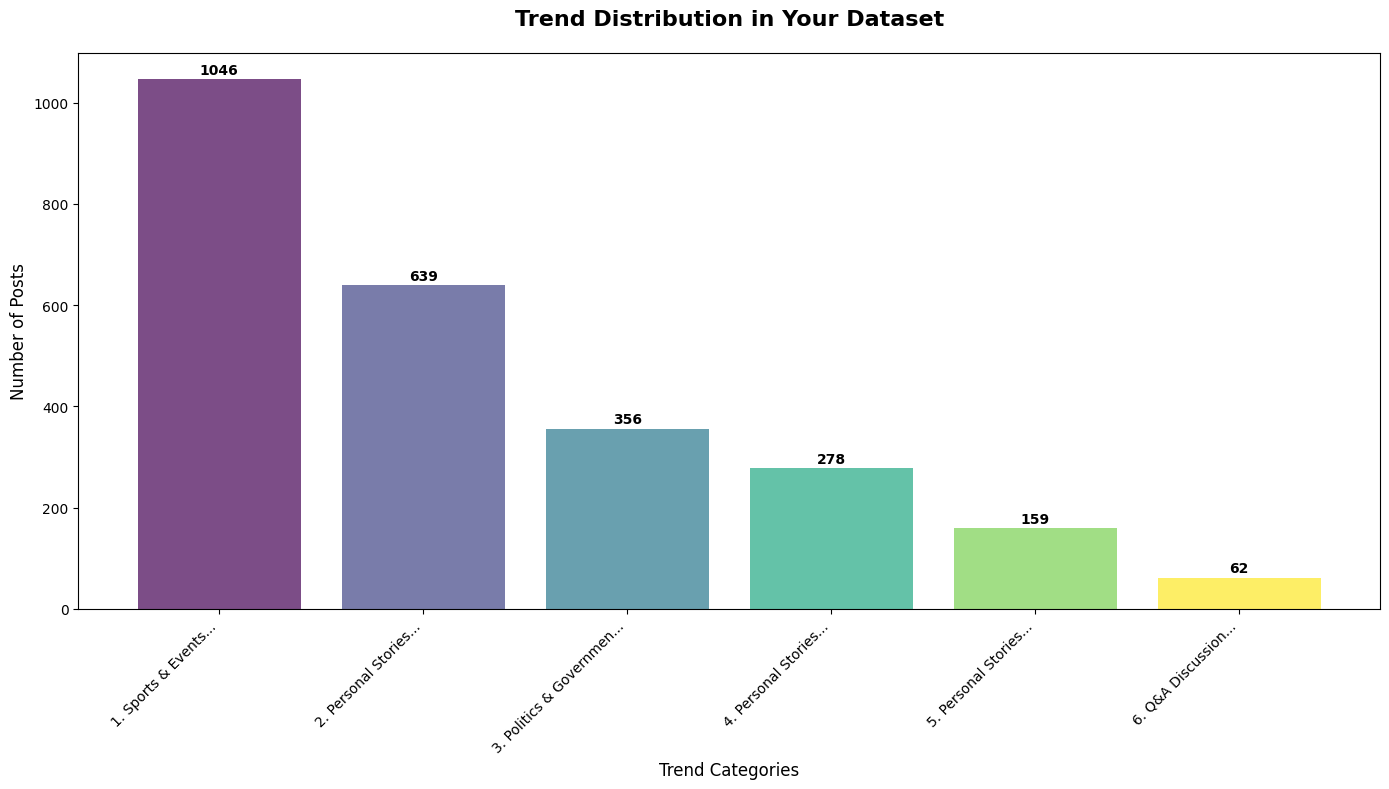


 SAMPLE OF RAW DATA (first 3 posts):
--------------------------------------------------
1. your dog looks very similar to my dog how old is your dog...
2. your chemistry puns are so basic...
3. because the fact that we waste our time with their nonsense asylum claims is bullshit already name a country in central and south america that you per...


In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print(" TREND DETECTION WITH  DATASET")
print("=" * 60)

# Load YOUR dataset - UPDATE THIS PATH
df = pd.read_csv('clustered_data.csv')  # ⚠️ CHANGE TO YOUR ACTUAL FILE PATH

print(f"  dataset shape: {df.shape}")
print(f" Columns: {df.columns.tolist()}")

# Auto-detect the text column
text_column = None
text_candidates = ['clean_text', 'text', 'body', 'content', 'message', 'tweet', 'post', 'comment']

for candidate in text_candidates:
    if candidate in df.columns:
        text_column = candidate
        break

if text_column is None:
    # Use first string column
    string_cols = df.select_dtypes(include=['object']).columns
    text_column = string_cols[0] if len(string_cols) > 0 else df.columns[0]

print(f" Using text column: '{text_column}'")

# Sample your data for faster processing (adjust based on your dataset size)
if len(df) > 10000:
    df_analysis = df.sample(n=10000, random_state=42)
    print(f"Using sample of 10,000 posts for faster analysis")
else:
    df_analysis = df.copy()
    print(f" Using all {len(df)} posts")

def extract_real_trends(df, text_column, n_trends=8):
    """
    Extract actual meaningful trends 
    """
   
    
    # Clean the text data
    texts = df[text_column].fillna('').astype(str)
    
    # Remove very short texts and clean
    cleaned_texts = []
    for text in texts:
        if len(text.strip()) > 25:  # Only keep meaningful length texts
            # Basic cleaning
            text = re.sub(r'http\S+', '', text)  # Remove URLs
            text = re.sub(r'@\w+', '', text)     # Remove mentions
            text = re.sub(r'[^\w\s]', ' ', text) # Remove special chars
            text = ' '.join(text.split())        # Remove extra spaces
            cleaned_texts.append(text.lower())
    
    print(f"   After cleaning: {len(cleaned_texts)} valid posts")
    
    # Use TF-IDF with focus on specific terms (not generic words)
    print("Analyzing text patterns...")
    vectorizer = TfidfVectorizer(
        max_features=800,
        stop_words='english',
        min_df=5,           # Ignore very rare terms
        max_df=0.4,         # Ignore overly common terms (more aggressive)
        ngram_range=(1, 2), # Include phrases
        analyzer='word'
    )
    
    X = vectorizer.fit_transform(cleaned_texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"   Vocabulary size: {len(feature_names)} terms")
    
    # Cluster to find trends
    print(" Clustering for trend discovery...")
    kmeans = KMeans(n_clusters=n_trends, random_state=42, n_init=5)
    cluster_labels = kmeans.fit_predict(X)
    
    # Analyze each cluster for trends
    trends = []
    
    for cluster_id in range(n_trends):
        cluster_mask = cluster_labels == cluster_id
        cluster_texts = [cleaned_texts[i] for i in range(len(cleaned_texts)) if cluster_labels[i] == cluster_id]
        
        if len(cluster_texts) > 10:  # Only consider substantial clusters
            # Get top keywords with better filtering
            word_scores = np.array(X[cluster_mask].sum(axis=0)).flatten()
            top_indices = word_scores.argsort()[-20:][::-1]  # Get more words for context
            raw_keywords = [feature_names[idx] for idx in top_indices]
            
            # Filter out generic words and get meaningful keywords
            meaningful_keywords = filter_meaningful_keywords(raw_keywords, cluster_texts)
            
            if meaningful_keywords:  # Only if we found meaningful keywords
                trend_topic = identify_trend_topic(meaningful_keywords, cluster_texts)
                
                trends.append({
                    'trend_id': cluster_id,
                    'topic': trend_topic,
                    'size': len(cluster_texts),
                    'percentage': (len(cluster_texts) / len(cleaned_texts)) * 100,
                    'keywords': meaningful_keywords[:8],  # Top 8 meaningful keywords
                    'sample_posts': cluster_texts[:3],    # Sample posts for context
                    'engagement_score': calculate_engagement(cluster_texts)
                })
    
    # Sort by size (most popular trends first)
    return sorted(trends, key=lambda x: x['size'], reverse=True)

def filter_meaningful_keywords(keywords, texts):
    """
    Filter out generic words to find meaningful trend indicators
    """
    # Common generic words that don't indicate specific trends
    generic_words = {
        'like', 'just', 'know', 'think', 'people', 'really', 'would', 'could', 
        'should', 'dont', 'cant', 'wont', 'get', 'got', 'see', 'look', 'said',
        'say', 'make', 'made', 'time', 'good', 'great', 'bad', 'better', 'best',
        'right', 'wrong', 'way', 'thing', 'things', 'stuff', 'something', 'anything',
        'maybe', 'probably', 'actually', 'literally', 'basically', 'seriously'
    }
    
    # Filter and score keywords
    meaningful = []
    for keyword in keywords:
        if (keyword not in generic_words and 
            len(keyword) > 2 and 
            not keyword.isdigit()):
            
            # Check if this keyword appears in multiple posts (indicates trend)
            keyword_count = sum(1 for text in texts if keyword in text.lower())
            if keyword_count > len(texts) * 0.1:  # Appears in at least 10% of cluster
                meaningful.append(keyword)
    
    return meaningful[:15]  # Return top 15 meaningful keywords

def identify_trend_topic(keywords, texts):
    """
    Identify what kind of trend this cluster represents
    """
    all_text = ' '.join(texts).lower()
    keyword_str = ' '.join(keywords).lower()
    
    # Trend categories with specific indicators
    categories = {
        'Politics & Government': [
            'trump', 'biden', 'president', 'election', 'government', 'senate', 'congress',
            'vote', 'law', 'policy', 'democrat', 'republican', 'administration', 'bill'
        ],
        'Entertainment & Movies': [
            'movie', 'film', 'marvel', 'disney', 'netflix', 'actor', 'director',
            'trailer', 'scene', 'character', 'plot', 'cinema', 'hollywood', 'oscar'
        ],
        'Gaming & Esports': [
            'game', 'gaming', 'player', 'playstation', 'xbox', 'nintendo', 'steam',
            'fortnite', 'minecraft', 'cod', 'level', 'character', 'multiplayer', 'console'
        ],
        'Technology & Apps': [
            'iphone', 'android', 'apple', 'google', 'facebook', 'twitter', 'instagram',
            'app', 'update', 'software', 'phone', 'tech', 'feature', 'device', 'computer'
        ],
        'Sports & Events': [
            'game', 'team', 'player', 'season', 'win', 'score', 'nfl', 'nba', 'mlb',
            'soccer', 'football', 'basketball', 'baseball', 'championship', 'tournament'
        ],
        'Social Issues': [
            'climate', 'environment', 'health', 'education', 'justice', 'rights',
            'equality', 'protest', 'movement', 'change', 'future', 'society', 'community'
        ],
        'Personal Stories': [
            'experience', 'story', 'life', 'family', 'friend', 'relationship',
            'work', 'job', 'school', 'home', 'parent', 'child', 'love'
        ],
        'Pop Culture': [
            'celebrity', 'famous', 'star', 'music', 'artist', 'album', 'song',
            'youtube', 'tiktok', 'influencer', 'viral', 'trending', 'meme'
        ]
    }
    
    # Score each category
    scores = {}
    for category, markers in categories.items():
        score = sum(1 for marker in markers if marker in keyword_str or marker in all_text)
        scores[category] = score
    
    # Get best matching category
    best_category = max(scores, key=scores.get)
    best_score = scores[best_category]
    
    # If no clear category, try to infer from keywords
    if best_score < 2:
        return infer_topic_from_keywords(keywords)
    else:
        return best_category

def infer_topic_from_keywords(keywords):
    """Infer topic when no clear category matches"""
    keyword_str = ' '.join(keywords).lower()
    
    if any(word in keyword_str for word in ['movie', 'film', 'show', 'actor']):
        return "Entertainment Discussion"
    elif any(word in keyword_str for word in ['game', 'play', 'player', 'win']):
        return "Gaming Discussion"
    elif any(word in keyword_str for word in ['phone', 'app', 'update', 'tech']):
        return "Technology Talk"
    elif any(word in keyword_str for word in ['time', 'day', 'week', 'year']):
        return "Current Events"
    elif any(word in keyword_str for word in ['question', 'help', 'advice', 'suggest']):
        return "Q&A Discussion"
    else:
        # Create a descriptive name from top keywords
        return f"Discussion about {', '.join(keywords[:2])}"

def calculate_engagement(texts):
    """Simple engagement metric based on text characteristics"""
    if not texts:
        return 0
    
    avg_length = np.mean([len(text.split()) for text in texts])
    question_count = sum(1 for text in texts if '?' in text)
    exclamation_count = sum(1 for text in texts if '!' in text)
    
    # Simple scoring (0-10)
    score = min(10, (avg_length / 15) + (question_count / len(texts) * 3) + (exclamation_count / len(texts) * 2))
    return round(score, 1)

# EXECUTE THE TREND ANALYSIS
print("\n ANALYZING TRENDS IN YOUR DATASET...")
trends = extract_real_trends(df_analysis, text_column, n_trends=8)


print(" TRENDS FOUND : ")


if not trends:
    print(" No clear trends detected. data might be too generic or need different processing.")
else:
    for i, trend in enumerate(trends, 1):
        print(f"\n{i}.  {trend['topic']}")
        print(f"    Volume: {trend['size']} posts ({trend['percentage']:.1f}% of data)")
        print(f"    Key Terms: {', '.join(trend['keywords'][:5])}")
        print(f"    Engagement Score: {trend['engagement_score']}/10")
        
       
        if trend['sample_posts']:
            print(f"    Sample Discussions:")
            for j, post in enumerate(trend['sample_posts'][:2], 1):
                preview = post[:120] + "..." if len(post) > 120 else post
                print(f"      {j}. {preview}")

    # Summary statistics
    print(f"\n TREND ANALYSIS SUMMARY:")
    print(f"   Total trends identified: {len(trends)}")
    print(f"   Most popular trend: '{trends[0]['topic']}' ({trends[0]['percentage']:.1f}% of posts)")
    print(f"   Total posts analyzed: {len(df_analysis)}")
    
    # Visualization
    plt.figure(figsize=(14, 8))
    trend_names = [f"{i+1}. {trend['topic'][:20]}..." for i, trend in enumerate(trends)]
    trend_sizes = [trend['size'] for trend in trends]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(trends)))
    bars = plt.bar(trend_names, trend_sizes, color=colors, alpha=0.7)
    
    plt.title('Trend Distribution in Your Dataset', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Trend Categories', fontsize=12)
    plt.ylabel('Number of Posts', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, size in zip(bars, trend_sizes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{size}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Additional: Show raw data sample for context
print(f"\n SAMPLE OF RAW DATA (first 3 posts):")
print("-" * 50)
for i in range(min(3, len(df_analysis))):
    text_preview = str(df_analysis.iloc[i][text_column])[:150] + "..." 
    print(f"{i+1}. {text_preview}")

In [7]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
from collections import Counter

print(" TREND DETECTION WITH STABILITY VALIDATION")
print("=" * 60)

# Load your dataset
df = pd.read_csv('clustered_data.csv')  

# Auto-detect text column
text_column = 'clean_text' if 'clean_text' in df.columns else df.columns[0]
print(f" Dataset: {df.shape}, Text column: '{text_column}'")

def robust_trend_analysis(df, text_column, sample_size=8000, n_clusters=8, n_validation_runs=3):
    """
    Robust trend analysis with multiple validation checks
    """
    
   
    if len(df) > sample_size:
        df_analysis = df.sample(n=sample_size, random_state=42)
        print(f"Using sample of {sample_size} posts")
    else:
        df_analysis = df.copy()
        print(f" Using all {len(df)} posts")
    
    # MAIN ANALYSIS on primary sample
    print("\n MAIN TREND ANALYSIS...")
    main_trends, X, feature_names = extract_trends_with_metrics(df_analysis, text_column, n_clusters)
    
    # STABILITY VALIDATION
    print("\n STABILITY VALIDATION...")
    stability_results = validate_trend_stability(df, text_column, n_runs=n_validation_runs)
    
    return main_trends, stability_results

def extract_trends_with_metrics(df, text_column, n_clusters):
 
    
    # Clean and vectorize
    texts = clean_texts(df[text_column])
    vectorizer = TfidfVectorizer(max_features=800, stop_words='english', min_df=5, max_df=0.4)
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Cluster with quality assessment
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
    labels = kmeans.fit_predict(X)
    
    # Calculate clustering quality
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else 0
    
    print(f" Clustering Quality:")
    print(f"   - Silhouette Score: {silhouette:.3f}")
    print(f"   - Cluster balance: {np.std(np.bincount(labels)):.1f} (lower = more balanced)")
    
    # Extract trends
    trends = []
    for cluster_id in range(n_clusters):
        cluster_mask = labels == cluster_id
        cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster_id]
        
        if len(cluster_texts) > len(texts) * 0.05:  # At least 5% of data
            trends.append(analyze_cluster_trend(cluster_id, cluster_texts, X, cluster_mask, feature_names))
    
    return sorted(trends, key=lambda x: x['size'], reverse=True), X, feature_names

def validate_trend_stability(df, text_column, n_runs=3, sample_size=4000):
    
    
    consistent_trends = Counter()
    
    for run in range(n_runs):
        df_sample = df.sample(n=min(sample_size, len(df)), random_state=run)
        texts = clean_texts(df_sample[text_column])
        
        if len(texts) > 100:  # Only run if we have enough data
            vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
            X = vectorizer.fit_transform(texts)
            
            kmeans = KMeans(n_clusters=6, random_state=run, n_init=3)
            labels = kmeans.fit_predict(X)
            
            # Simple trend detection for validation
            for cluster_id in range(6):
                cluster_mask = labels == cluster_id
                if cluster_mask.sum() > len(texts) * 0.1:  # Substantial cluster
                    cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster_id]
                    trend_topic = identify_trend_topic_simple(cluster_texts)
                    consistent_trends[trend_topic] += 1
    
    print(" Trends found across multiple runs:")
    for trend, count in consistent_trends.most_common():
        if count > 1:  
            print(f"    {trend}: {count}/{n_runs} runs")
    
    return consistent_trends

def identify_trend_topic_simple(texts):
    all_text = ' '.join(texts).lower()
    
    categories = {
        'Politics': ['trump', 'biden', 'election', 'government', 'president'],
        'Entertainment': ['movie', 'film', 'show', 'actor', 'character'],
        'Gaming': ['game', 'player', 'play', 'win', 'level'],
        'Technology': ['phone', 'app', 'update', 'tech', 'computer'],
        'Sports': ['game', 'team', 'player', 'win', 'season'],
        'Social': ['people', 'life', 'time', 'friend', 'family']
    }
    
    for category, keywords in categories.items():
        if any(keyword in all_text for keyword in keywords):
            return category
    
    return 'General Discussion'

def clean_texts(text_series):
    """Clean text data"""
    texts = []
    for text in text_series.fillna('').astype(str):
        if len(text.strip()) > 25:
            text = re.sub(r'http\S+', '', text)
            text = re.sub(r'[^\w\s]', ' ', text)
            text = ' '.join(text.split())
            texts.append(text.lower())
    return texts

def analyze_cluster_trend(cluster_id, cluster_texts, X, cluster_mask, feature_names):
    """Analyze a single cluster for trends"""
    word_scores = np.array(X[cluster_mask].sum(axis=0)).flatten()
    top_indices = word_scores.argsort()[-15:][::-1]
    raw_keywords = [feature_names[idx] for idx in top_indices]
    
    meaningful_keywords = [kw for kw in raw_keywords if kw not in 
                          {'like', 'just', 'know', 'think', 'people', 'really'}]
    
    trend_topic = identify_trend_topic_simple(cluster_texts)
    
    return {
        'trend_id': cluster_id,
        'topic': trend_topic,
        'size': len(cluster_texts),
        'keywords': meaningful_keywords[:6],
        'sample_posts': cluster_texts[:2]
    }

#  ROBUST ANALYSIS
print(" TREND ANALYSIS...")
main_trends, stability_results = robust_trend_analysis(df, text_column)


print("FINAL TREND REPORT")


for i, trend in enumerate(main_trends, 1):
    print(f"\n{i}. {trend['topic']}")
    print(f"    {trend['size']} posts | Keywords: {', '.join(trend['keywords'][:4])}")
    if trend['sample_posts']:
        print(f"    Sample: {trend['sample_posts'][0][:100]}...")

 TREND DETECTION WITH STABILITY VALIDATION
 Dataset: (1017100, 4), Text column: 'clean_text'
 TREND ANALYSIS...
Using sample of 8000 posts

 MAIN TREND ANALYSIS...
 Clustering Quality:
   - Silhouette Score: 0.025
   - Cluster balance: 1570.4 (lower = more balanced)

 STABILITY VALIDATION...
 Trends found across multiple runs:
    Politics: 5/3 runs
FINAL TREND REPORT

1. Politics
    5003 posts | Keywords: im, time, thats, good
    Sample: your dog looks very similar to my dog how old is your dog...

2. Politics
    579 posts | Keywords: im, good, game, doesnt
    Sample: she wasnt then except locally at that point she was just the presidents wife which leads to somethin...

3. Politics
    473 posts | Keywords: looks, look, feel, im
    Sample: id also like to propose we start using beacons for longdistance communition...

4. Politics
    460 posts | Keywords: dont, want, im, youre
    Sample: we just dont know we dont have clear evidence of what that progression would look like they